# How To Cut
## Utility-scale QAOA

So to date, I have developed Quantum Circuits to purely measure Entanglement in both a two-qubit bell state, and a 100-qubit GHZ state. It's time to actually solve a problem, specifically the Max-Cut optimisation problem. To do this we are going to be using our first Quantum Algorithm, QAOA. So as before, we are following along with a wonderful IBM tutorial, however, unlike IBM, we will be diving head first into some of the underlying theory and code in more detail. Really so we can start to build up a stronger foundation of knowledge rather than blindingly following the tutorial. So let's get into it. Beginning with some theory. 

### The Max Cut Problem
A rather innocent looking problem, the aim is to take a graph (e.g. a few nodes with edges/lines between them) and colour the nodes into one of two colours. If a edge (line) is then between two nodes of different colours, it is treated as cut. If the edge is between nodes of the same colour it is not. So it's not really cutting in the conventional sense. 

So let's take the graph below with 5 nodes & 6 edges. 

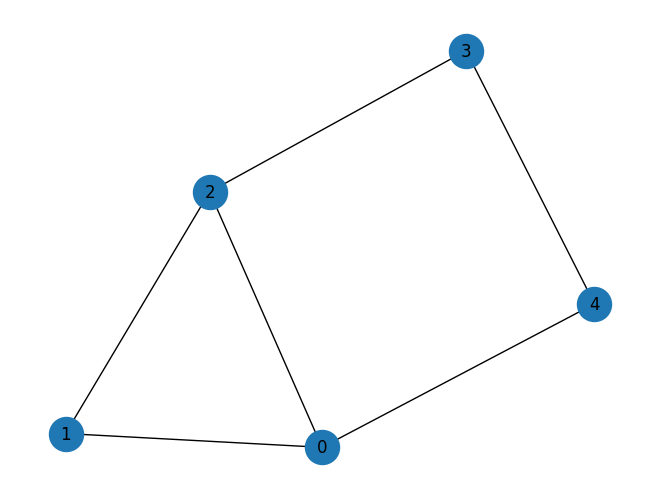

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

Now let's look at a graph, with three nodes marked as red, leading to two cuts. E.g. two lines that are connected by nodes with different colours.

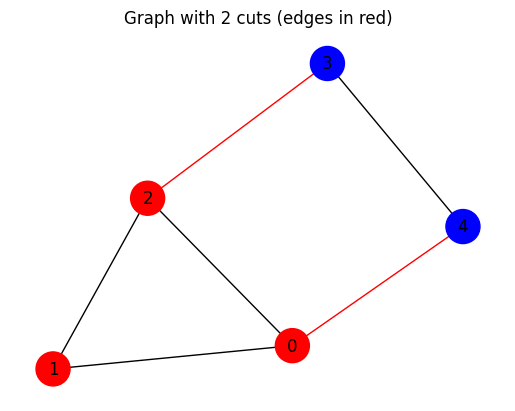

In [6]:
# Second graph with 2 cuts (partition: {0,1,2} vs {3,4})
color_map = ["red", "red", "red", "blue", "blue"]
cut_edges = [(2, 3), (0, 4)]  # These edges are "cut" between partitions

fig, ax = plt.subplots()
draw_graph(
    graph,
    node_size=600,
    with_labels=True,
    ax=ax,
    node_color=color_map,
    edge_color=["red" if (u, v) in cut_edges or (v, u) in cut_edges else "black" for u, v in graph.edge_list()]
)
plt.title("Graph with 2 cuts (edges in red)")
plt.show()

The aim of the max cut is to maximise the number of cuts. 

This is known as a NP-hard problem, an NP hard problem being one that has no known polynomial-time algorithm. A polynomial-time algorithm being one where time grows at most a polynomial function of the size of the input. 

Since, for Max Cut there is a \(\text{Number of nontrivial cuts} = 2^{n-1} - 1\) (this is exponential)

A real world utilities application includes:

#### Power Grid Optimisation

Let's say you are a system operator, and you need the ability to split your network into two smaller zones to allow manageable isolation of faults. So a fault in Zone A can be isolated so Zone B remains live.

Therefore, Max-Cut allows you to pinpoint the exact transmission lines to sectionalize so a fault in one segment won’t cascade across the entire grid. By maximizing the sum of high-capacity inter-zone lines, you create clear boundary points where breakers or switches can isolate a disturbance in seconds. 

In the event of a substation failure or line overload, operators open those boundary devices to confine the fault and prevent overloads on adjacent lines. Meanwhile, the unaffected segment stays energized, ensuring that critical loads like hospitals, data centers, and emergency services remain online. This targeted approach to resilience lets utilities reinforce or automate those key links for faster fault restoration and fewer widespread outages.

#### Load Balancing in Energy Distribution

During peak demand periods, some regions face overload risks while others run below capacity. Modeling the grid as a weighted graph and applying Max-Cut reveals the partition with the greatest transmission capacity between zones. Operators can then reroute power along these high capacity inter-zone ties (that are cut), shifting surplus energy from low-demand areas into high-demand regions without overstressing local infrastructure. By leaning on the strongest connections, the grid balances loads more evenly, reducing the likelihood of line sag, transformer overheating, and voltage instability. The result is a dynamically adaptive network that maintains reliable service even as consumption patterns swing wildly.

#### Maintenance Scheduling

Routine maintenance often requires de-energizing parts of the grid, which risks downtime and customer inconvenience. A Max-Cut-based partition shows exactly which breakers to open to isolate one segment while keeping the rest of the network live. Crews can safely work on lines, transformers, or switchgear within the offline zone without impacting other areas. Because the cut maximizes boundary capacity, any unintended load shifts are absorbed by the still-energized segment’s infrastructure. This surgical isolation minimizes planned outages, enhances technician safety, and keeps power flowing for the majority of users.

### The QAOA 

Quantum Approximate Optimization Algorithm is a hybrid quantum-classical algorithm that allows you to find approximate solutions, where you:
1. Encode the problem into a quantum system
2. Apply a series of quantum operations
3. Measure the outcome
4. Use a classical optimiser to tune free parameters (2p variational angles), and re-run. The objective is to explore the parameter landscape. 

## Step 1: Mapping the Problem

To solve the classical problem with Quantum Computing, we need to begin by turning it into quantum circuits and operators. Doing this requires us to do three things:

### A. Turn the graph problem into an optimisation problem (through mathematical reformulations) using QUBO notation:

So let's think about what the classical problem might look like, so we know the aim of the game is finding the minimal of a function f (x)

$$
\min_{x \in \{0,1\}^n} f(x)
$$

We also know that for a given edge, if either the nodes are different from the other e.g. one is 0, and the is 1. Then the edge is cut. This can be expressed as:

$$
\max_{x \in \{0,1\}^n} \sum_{i,j} (x_i + x_j - 2 x_i x_j)
$$

this maximisation can be then rewritten as the minimisation

$$
\min{x \in \{0,1\}^n} \sum_{i,j} (2 x_i x_j - x_i - x_j)
$$

The MaxCut problem can be expressed in the following QUBO notation:

$$
\max_{x \in \{0,1\}^n} x^T Q x
$$

where Q is a n x n matrix of real numbers, The dimension n matches the number of nodes in your graph, x is the vector of binary variables, and XT indicates the transpose of the vector x. 

Don't get too bogged down in the maths for now, I spent an hour trying to figure it out and failed.

####  What is QUBO notation?
S

### B. Turn the optimisation problem into a Hamiltonian

**Callout**
What is a Hamiltonian?

In quantum mechanics, its an operator that represents the total energy if the system. In the context of Max-Cut, we construct a Hamiltonian where the lowest energy state (ground state) corresponds to the optimal solution of the problem. Problems that can be encoded into Hamiltonians are often those with discrete variables such as Max Cut where each vertex is a qubit, which can be 0 or 1. 



$$
H_C \;=\; \sum_{i<j} Q_{ij}\, Z_i Z_j \;+\; \sum_i b_i\, Z_i
$$

This resulting cost function Hamiltonian, has a ground state that corresponds to a minimal cost function. In other words, the energy is minimised when the connected vertices are in opposite sets (leading to a maximum cut). Now each Vertex will be associated with a qubit in state ∣0⟩ or ∣1⟩. So we can associate the Z operator with each qubit:

Z∣0⟩=∣0⟩   Z∣1⟩=−∣1⟩

**Callout**
What is the Z operator?

Pauli-Z operator, one of the three Pauli matrices used to manipulate qubits. The Pauli-Z gate is a phase-flip gate: it changes the phase of ∣1⟩ but not ∣0⟩.

Therefore, we know when an edge ($v_1, v_2$) belongs to the cut if the eigenvalue of 
$$
\left( Z_1 \lvert v_1 \rangle \right) \cdot \left( Z_2 \lvert v_2 \rangle \right) = -1
$$


Addiitonally, in this case, we are treating all vertexes as symmetric. We don't care if its 0 or 1. Therefore, we can set the bias term bi = 0 since there is no preference. Leading to:

$$
H_C \;=\; \sum_{i<j} Q_{ij}\, Z_i Z_j \
$$

In this case, we are also making it unweighted, $ Q_{ij} = 1 $ e.g. the edges are either present or not, they are not weighted. In a weighted graph, you would make some edges more valuable to cut than others.

$$
H_C \;=\; \sum_{i<j} Z_i Z_j \
$$

Finally! We have a hamiltonian to define:

In [10]:


def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    "Input: graph (an object with nodes and edges). Output: list of Pauli terms for Max-Cut Hamiltonian."
    pauli_list = [] # To hold the Pauli terms
    for edge in list(graph.edge_list()): # Iterate over each edge in the graph
        weight = graph.get_edge_data(edge[0], edge[1]) # Get the weight of the edge
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight)) # Append the Pauli term for this edge
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
print("Max-Cut Pauli List:", max_cut_paulis)

Max-Cut Pauli List: [('ZZ', [0, 1], 1.0), ('ZZ', [0, 2], 1.0), ('ZZ', [0, 4], 1.0), ('ZZ', [1, 2], 1.0), ('ZZ', [2, 3], 1.0), ('ZZ', [3, 4], 1.0)]


Notice that all have an equal weight! With the brackets denoting the edge, and the corresponding edge.

A Pauli List is:


In [ ]:
from qiskit.quantum_info import SparsePauliOp
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
# Convert the Pauli list to a SparsePauliOp. Using n, it pads with I's for qubits not ZZ-ed.
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### C. Create the quantum circuit


